In [1]:
import torch
torch.__version__

'1.6.0+cu101'

In [2]:
%matplotlib inline

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torchvision import transforms, models

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def load_image(path, max_size=500, shape=None):
  image = Image.open(path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406),
                           (0.229, 0.224, 0.225))
  ])

  image = transform(image)[:3,:,:].unsqueeze(0)

  return image 

In [50]:
content = load_image('/content/lisa.jpeg').to(device)
style = load_image('/content/Abstract_5105.jpeg', shape=content.shape[-2:]).to(device) 

In [51]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0,1)

  return image

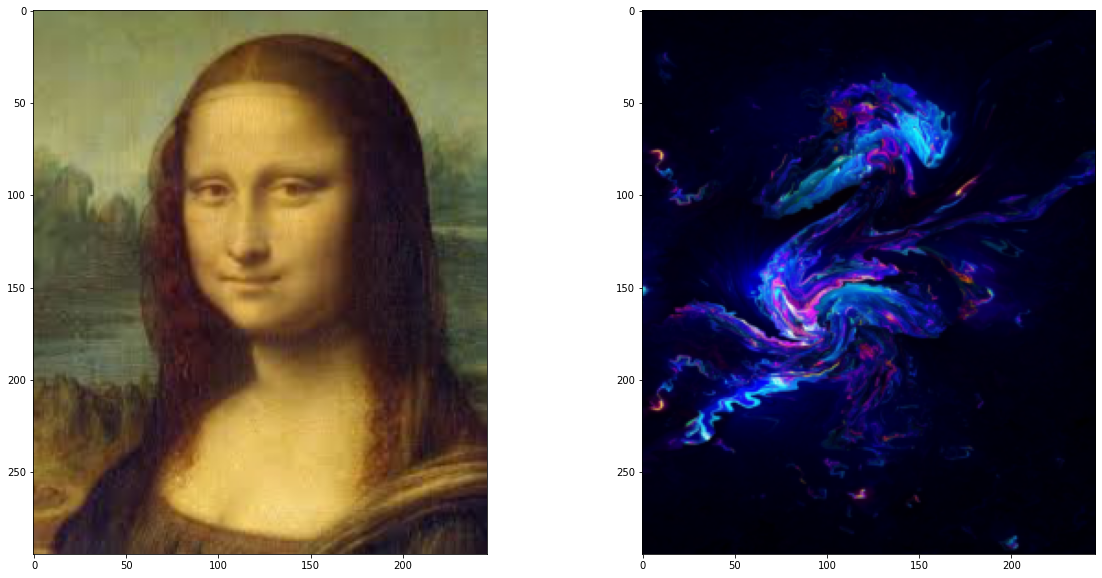

In [52]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [53]:
def get_features(image, model, layers=None):

  if layers is None:
    layers ={'0':'conv1_1',
             '5':'conv2_1',
             '10':'conv3_1',
             '19':'conv4_1',
             '21':'conv4_2',
             '28':'conv5_1'}
             
  features = {}
  x = image

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
        features[layers[name]] = x

  return features

In [54]:
def gram_matrix(tensor):
  _, depth, height, width = tensor.size()
  tensor =  tensor.view(depth, height*width)

  gram  = torch.mm(tensor, tensor.t())

  return gram

In [55]:
content_feats = get_features(content, vgg)
style_feats = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_feats[layer]) for layer in style_feats}

target = content.clone().requires_grad_(True).to(device)

In [57]:
style_weights = {'conv1_1': 1.,
                 'conv2_1' : 0.8,
                 'conv3_1' : 0.45,
                 'conv4_1' : 0.2,
                 'conv5_1' : 0.2}

alpha = 1
beta = 1e6 #1x10^6

Total loss :  45993184.0


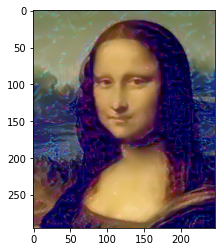

Total loss :  18165236.0


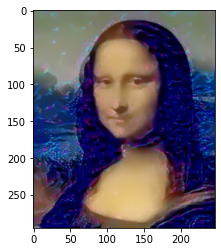

Total loss :  12087045.0


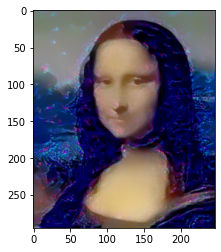

Total loss :  8584050.0


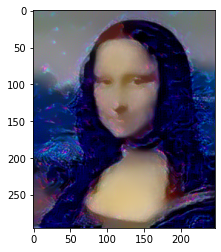

Total loss :  6297119.0


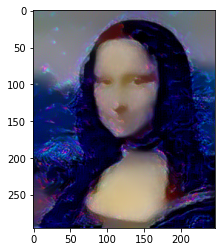

In [58]:
every = 400

optimizer = optim.Adam([target], lr=0.003)
steps = 2000


for i in range(1, steps+1):

  target_feats = get_features(target, vgg)

  content_loss = torch.mean((target_feats['conv4_2'] - content_feats['conv4_2'])**2)


  style_loss = 0

  for layer in style_weights:

    target_feat = target_feats[layer]
    _, depth, height, width = target_feat.shape

    target_gram = gram_matrix(target_feat)

    style_gram = style_grams[layer]

    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

    style_loss += layer_loss/ (depth*height*width) 


  total_loss = alpha*content_loss + beta*style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if i % every == 0:
    print("Total loss : ", total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()